In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [4]:
training_data = datasets.FashionMNIST(
    root = 'data',
    train=True, # True = train, False = test
    download = True,
    transform = ToTensor() # numpy 배열의 이미지를 torch 텐서로 바꾸어준다.
)

26422272it [00:55, 479283.26it/s]                              
Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw
29696it [00:00, 99355.90it/s]                           
Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw
4422656it [00:03, 1157493.04it/s]                             
Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw
6144it [00:00, 4129114.53it/s]          
C:\Users\alscj\anaconda3\envs\Torch\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tenso

In [6]:
test_data = datasets.FashionMNIST(
    root = 'data',
    train=False, # True = train, False = test
    download = True,
    transform = ToTensor() # numpy 배열의 이미지를 torch 텐서로 바꾸어준다.
)

In [8]:
batch_size = 64 #64개의 데이터를 하나의 step으로 보낸다. 
# DataLoader = Dataset으로 데이터를 불러올경우 검색을 통해 features와 label을 한번만 들고 오는 것이다 이에 sample을 minibatches를 통해 통과시키고 model의 오버피팅을 줄이기 위해 매 epoch에 data를 reshuffle하고 multiprocessing을 사용하기 위해서는 DataLoader를 사용하여야 한다.
train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y:", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


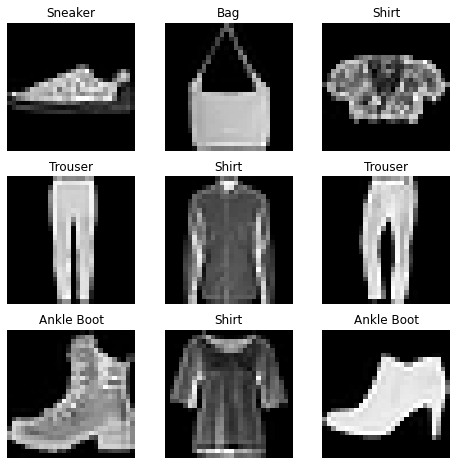

In [10]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten() # 1차원
        self.main = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512,10),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.main(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
from tqdm import tqdm

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred,y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch *len(X)
            print(f"loss: {loss:>7f}   [{current:>5d}/{size:>5d}]")

In [20]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [23]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 1.535316   [    0/60000]
loss: 1.686954   [ 6400/60000]
loss: 1.429207   [12800/60000]
loss: 1.540702   [19200/60000]
loss: 1.529860   [25600/60000]
loss: 1.376941   [32000/60000]
loss: 1.470082   [38400/60000]
loss: 1.377737   [44800/60000]
loss: 1.435676   [51200/60000]
loss: 1.283492   [57600/60000]
Test Error: 
 Accuracy: 50.8%, Avg loss: 0.022903 

Epoch 2
-------------------------------
loss: 1.439096   [    0/60000]
loss: 1.610987   [ 6400/60000]
loss: 1.333321   [12800/60000]
loss: 1.464269   [19200/60000]
loss: 1.450096   [25600/60000]
loss: 1.302566   [32000/60000]
loss: 1.396535   [38400/60000]
loss: 1.296499   [44800/60000]
loss: 1.317374   [51200/60000]
loss: 1.195800   [57600/60000]
Test Error: 
 Accuracy: 52.5%, Avg loss: 0.020943 

Epoch 3
-------------------------------
loss: 1.277341   [    0/60000]
loss: 1.464576   [ 6400/60000]
loss: 1.206597   [12800/60000]
loss: 1.410275   [19200/60000]
loss: 1.236105   [25600/60000]
l

In [24]:
torch.save(model.state_dict(), "model.pth")
print("Saved Pytorch Model State to model.pth")

Saved Pytorch Model State to model.pth


In [25]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [32]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
